# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [23]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.411549
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [24]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.403668 analytic: 1.403668, relative error: 2.837424e-08
numerical: 3.551120 analytic: 3.551120, relative error: 2.236369e-08
numerical: -3.917369 analytic: -3.917369, relative error: 6.532137e-09
numerical: 0.801582 analytic: 0.801583, relative error: 2.108570e-08
numerical: -2.356545 analytic: -2.356545, relative error: 4.684597e-09
numerical: 0.710695 analytic: 0.710695, relative error: 3.156065e-08
numerical: -2.032230 analytic: -2.032230, relative error: 1.019651e-09
numerical: 0.692318 analytic: 0.692318, relative error: 8.460313e-08
numerical: -0.849934 analytic: -0.849934, relative error: 5.653895e-08
numerical: 1.730491 analytic: 1.730491, relative error: 3.045618e-08
numerical: 1.407678 analytic: 1.407678, relative error: 6.142212e-08
numerical: 0.687454 analytic: 0.687454, relative error: 2.438281e-08
numerical: 0.301756 analytic: 0.301756, relative error: 1.103749e-07
numerical: -0.357730 analytic: -0.357730, relative error: 3.140788e-08
numerical: -0.916877 ana

In [26]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.411549e+00 computed in 0.103112s
vectorized loss: 2.411549e+00 computed in 0.008180s
Loss difference: 0.000000
Gradient difference: 0.000000


In [37]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
#search in a wide range
#learning_rates = [1e-7, 5e-7]
learning_rates = [10 ** (-f) for f in np.arange(4, 7, 0.5)]
#regularization_strengths = [2.5e4, 5e4]
regularization_strengths = [10 ** (f) for f in np.arange(2, 5, 0.5)]
best_para = {}
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg_s in regularization_strengths:
        print('lr: ', lr, ' reg: ', reg_s)
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, lr, reg_s, num_iters = 1000, batch_size = 200, verbose = True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        train_acc = np.mean(y_train_pred == y_train)
        val_acc = np.mean(y_val_pred == y_val)
        results[(lr, reg_s)] = [train_acc, val_acc]
        if (val_acc > best_val):
            best_val = val_acc
            best_softmax = softmax
            best_para['lr'] = lr
            best_para['reg_s'] = reg_s
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best para is: ', 'lr: ', best_para['lr'], ' reg ', best_para['reg_s'])

lr:  0.0001  reg:  100.0
iteration 0 / 1000: loss 10.875529
iteration 100 / 1000: loss 19.124820
iteration 200 / 1000: loss 36.685042
iteration 300 / 1000: loss 34.505450
iteration 400 / 1000: loss 26.393051
iteration 500 / 1000: loss 32.918202
iteration 600 / 1000: loss 29.921817
iteration 700 / 1000: loss 48.302904
iteration 800 / 1000: loss 49.329750
iteration 900 / 1000: loss 38.981933
lr:  0.0001  reg:  316.227766017
iteration 0 / 1000: loss 25.366381
iteration 100 / 1000: loss 55.359676
iteration 200 / 1000: loss 40.041910
iteration 300 / 1000: loss 45.131980
iteration 400 / 1000: loss 47.556930
iteration 500 / 1000: loss 54.412523
iteration 600 / 1000: loss 32.467596
iteration 700 / 1000: loss 31.917364
iteration 800 / 1000: loss 31.935881
iteration 900 / 1000: loss 42.655833
lr:  0.0001  reg:  1000.0
iteration 0 / 1000: loss 67.015549
iteration 100 / 1000: loss 77.874811
iteration 200 / 1000: loss 80.198055
iteration 300 / 1000: loss 55.803166
iteration 400 / 1000: loss 54.8462

cs231n/classifiers/softmax.py:85: RuntimeWarning: divide by zero encountered in log
  loss += np.sum(-1 * np.log(prob[np.arrange(num_train), y]))


iteration 800 / 1000: loss 104.276568
iteration 900 / 1000: loss 98.465312
lr:  0.0001  reg:  10000.0
iteration 0 / 1000: loss 613.178691
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss inf
iteration 700 / 1000: loss inf
iteration 800 / 1000: loss inf
iteration 900 / 1000: loss inf
lr:  0.0001  reg:  31622.7766017
iteration 0 / 1000: loss 1963.459852
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf


cs231n/classifiers/softmax.py:95: RuntimeWarning: overflow encountered in double_scalars
  loss += 2 * reg * np.sum(W * W)
cs231n/classifiers/softmax.py:95: RuntimeWarning: overflow encountered in multiply
  loss += 2 * reg * np.sum(W * W)


iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf


cs231n/classifiers/softmax.py:82: RuntimeWarning: overflow encountered in subtract
  scores -= max_scores
cs231n/classifiers/softmax.py:92: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W


iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
lr:  3.16227766017e-05  reg:  100.0
iteration 0 / 1000: loss 13.238726
iteration 100 / 1000: loss 13.768072
iteration 200 / 1000: loss 10.731203
iteration 300 / 1000: loss 7.067743
iteration 400 / 1000: loss 7.730323
iteration 500 / 1000: loss 9.333310
iteration 600 / 1000: loss 6.212234
iteration 700 / 1000: loss 13.341650
iteration 800 / 1000: loss 9.727821
iteration 900 / 1000: loss 10.315443
lr:  3.16227766017e-05  reg:  316.227766017
iteration 0 / 1000: loss 23.840340
iteration 100 / 1000: loss 11.786514
iteration 200 / 1000: loss 12.000921
iteration 300 / 1000: loss 10.061289
iteration 400 / 1000: loss 15.625437
iteration 500 / 1000: loss 13.681806
iteration 600 / 1000: loss 9.739591
iteration 700 / 1000: loss 9.218054
iteration 800 / 1000: loss 11.153086
iteration 900 / 1000: loss 8.597154
lr:  3.16227766017e-05  reg:  1000.0


iteration 300 / 1000: loss 19.694312
iteration 400 / 1000: loss 13.707133
iteration 500 / 1000: loss 9.743089
iteration 600 / 1000: loss 6.970606
iteration 700 / 1000: loss 5.392959
iteration 800 / 1000: loss 4.211689
iteration 900 / 1000: loss 3.485440
lr:  1e-06  reg:  3162.27766017
iteration 0 / 1000: loss 200.491340
iteration 100 / 1000: loss 56.570915
iteration 200 / 1000: loss 17.097522
iteration 300 / 1000: loss 6.181299
iteration 400 / 1000: loss 3.224285
iteration 500 / 1000: loss 2.303276
iteration 600 / 1000: loss 2.110834
iteration 700 / 1000: loss 1.960614
iteration 800 / 1000: loss 1.925620
iteration 900 / 1000: loss 1.974455
lr:  1e-06  reg:  10000.0
iteration 0 / 1000: loss 617.912817
iteration 100 / 1000: loss 12.705064
iteration 200 / 1000: loss 2.301180
iteration 300 / 1000: loss 2.111014
iteration 400 / 1000: loss 2.064173
iteration 500 / 1000: loss 2.120894
iteration 600 / 1000: loss 2.095490
iteration 700 / 1000: loss 2.114981
iteration 800 / 1000: loss 2.116794
i

In [42]:
lr_val = []
reg_val = []

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    #print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
    #            lr, reg, train_accuracy, val_accuracy))
    lr_val.append([lr, val_accuracy])
    reg_val.append([reg, val_accuracy])

lr_scatter = [x[0] for x in results]
reg_scatter = [x[1] for x in results]

#plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
#visualize result and selet the best range.
plt.figure(1)
plt.scatter(lr_val[:, 0], lr_val[:, 1])
plt.show()

plt.figure(2)
plt.scatter(reg_val[:, 0], reg_val[:, 1])
plt.show()

TypeError: list indices must be integers, not tuple

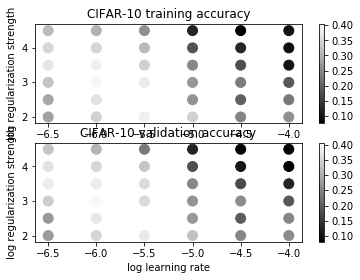

In [43]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [38]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.372000


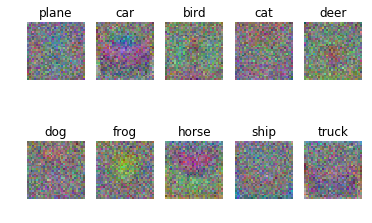

In [39]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])